In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

from sklearn.neural_network import MLPClassifier

We're ready to build our first neural network. We will have multiple features we feed into our model, each of which will go through a set of perceptron models to arrive at a response which will be trained to our output.

Like many models we've covered, this can be used as both a regression or classification model.

First, we need to load our dataset. For this example we'll use The Museum of Modern Art in New York's [public dataset](https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv) on their collection.

In [2]:
artworks = pd.read_csv('https://media.githubusercontent.com/media/MuseumofModernArt/collection/master/Artworks.csv')

In [3]:
artworks.columns

Index(['Title', 'Artist', 'ConstituentID', 'ArtistBio', 'Nationality',
       'BeginDate', 'EndDate', 'Gender', 'Date', 'Medium', 'Dimensions',
       'CreditLine', 'AccessionNumber', 'Classification', 'Department',
       'DateAcquired', 'Cataloged', 'ObjectID', 'URL', 'ThumbnailURL',
       'Circumference (cm)', 'Depth (cm)', 'Diameter (cm)', 'Height (cm)',
       'Length (cm)', 'Weight (kg)', 'Width (cm)', 'Seat Height (cm)',
       'Duration (sec.)'],
      dtype='object')

We'll also do a bit of data processing and cleaning, selecting columns of interest and converting URL's to booleans indicating whether they are present.

In [4]:
# Select Columns.
artworks = artworks[['Artist', 'Nationality', 'Gender', 'Date', 'Department',
                    'DateAcquired', 'URL', 'ThumbnailURL', 'Height (cm)', 'Width (cm)']]

# Convert URL's to booleans.
artworks['URL'] = artworks['URL'].notnull()
artworks['ThumbnailURL'] = artworks['ThumbnailURL'].notnull()

# Drop films and some other tricky rows.
artworks = artworks[artworks['Department']!='Film']
artworks = artworks[artworks['Department']!='Media and Performance Art']
artworks = artworks[artworks['Department']!='Fluxus Collection']

# Drop missing data.
artworks = artworks.dropna()

In [5]:
artworks.head()

,Artist,Nationality,Gender,Date,Department,DateAcquired,URL,ThumbnailURL,Height (cm),Width (cm)
0,Otto Wagner,(Austrian),(Male),1896,Architecture & Design,1996-04-09,True,True,48.6000,168.9000
1,Christian de Portzamparc,(French),(Male),1987,Architecture & Design,1995-01-17,True,True,40.6401,29.8451
2,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,34.3000,31.8000
3,Bernard Tschumi,(),(Male),1980,Architecture & Design,1995-01-17,True,True,50.8000,50.8000
4,Emil Hoppe,(Austrian),(Male),1903,Architecture & Design,1997-01-15,True,True,38.4000,19.1000


## Building a Model

Now, let's see if we can use multi-layer perceptron modeling (or "MLP") to see if we can classify the department a piece should go into using everything but the department name.

Before we import MLP from SKLearn and establish the model we first have to ensure correct typing for our data and do some other cleaning.

In [6]:
# Get data types.
artworks.dtypes

Artist           object
Nationality      object
Gender           object
Date             object
Department       object
DateAcquired     object
URL                bool
ThumbnailURL       bool
Height (cm)     float64
Width (cm)      float64
dtype: object

The `DateAcquired` column is an object. Let's transform that to a datetime object and add a feature for just the year the artwork was acquired.

In [5]:
artworks['DateAcquired'] = pd.to_datetime(artworks.DateAcquired)
artworks['YearAcquired'] = artworks.DateAcquired.dt.year
artworks['YearAcquired'].dtype

dtype('int64')

Great. Let's do some more miscellaneous cleaning.

In [116]:
len(set(artworks.Artist)), len(artworks)

(9171, 106643)

In [36]:
# Remove multiple nationalities, genders, and artists.
artworks.loc[artworks['Gender'].str.contains('\) \('), 'Gender'] = '\(multiple_persons\)'
artworks.loc[artworks['Nationality'].str.contains('\) \('), 'Nationality'] = '\(multiple_nationalities\)'
artworks.loc[artworks['Artist'].str.contains(','), 'Artist'] = 'Multiple_Artists'

# Convert dates to start date, cutting down number of distinct examples.
artworks['Date'] = pd.Series(artworks.Date.str.extract(
    '([0-9]{4})', expand=False))[:-1]

# Final column drops and NA drop.
X = artworks.drop(['Department', 'DateAcquired', 'Artist', 'Nationality', 'Date'], 1)

# Create dummies separately.
artists = pd.get_dummies(artworks.Artist)
nationalities = pd.get_dummies(artworks.Nationality)
dates = pd.get_dummies(artworks.Date)

# Concat with other variables, but artists slows this wayyyyy down so we'll keep it out for now
X = pd.get_dummies(X)
X = pd.concat([X, nationalities, dates], axis=1)

Y = artworks.Department

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [ ]:
# Alright! We've done our prep, let's build the model.
# Neural networks are hugely computationally intensive.
# This may take several minutes to run.

# Import the model.
from sklearn.neural_network import MLPClassifier

# Establish and fit the model, with a single, 1000 perceptron layer.
mlp = MLPClassifier(hidden_layer_sizes=(1000,))
mlp.fit(X_train, y_train)

In [ ]:
mlp.score(X_test, y_test)

In [11]:
y_test.value_counts()/len(y_test)

Prints & Illustrated Books    0.521662
Photography                   0.229354
Architecture & Design         0.111225
Drawings                      0.103381
Painting & Sculpture          0.034377
Name: Department, dtype: float64

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X_train, y_train, cv=5)

array([ 0.57519536,  0.52577072,  0.36922856,  0.48580744,  0.54039799])

Now we got a lot of information from all of this. Firstly we can see that the model seems to overfit, though there is still so remaining performance when validated with cross validation. This is a feature of neural networks that aren't given enough data for the number of features present. _Neural networks, in general, like_ a lot _of data_. You may also have noticed something also about neural networks: _they can take a_ long _time to run_. Try increasing the layer size by adding a zero. Feel free to interrupt the kernel if you don't have time...

Also note that we created bools for artist's name but left them out. Both of the above points are the reason for that. It would take much longer to run and it would be much more prone to overfitting.

## Model parameters

Now, before we move on and let you loose with some tasks to work on the model, let's go over the parameters.

We included one parameter: hidden layer size. Remember in the previous lesson, when we talked about layers in a neural network. This tells us how many and how big to make our layers. Pass in a tuple that specifies each layer's size. Our network is 1000 neurons wide and one layer. (100, 4, ) would create a network with two layers, one 100 wide and the other 4.

How many layers to include is determined by two things: computational resources and cross validation searching for convergence. It's generally less than the number of input variables you have.

You can also set an alpha. Neural networks like this use a regularization parameter that penalizes large coefficients just like we discussed in the advanced regression section. Alpha scales that penalty.

Lastly, we'll discuss the activation function. The activation function determines whether the output from an individual perceptron is binary or continuous. By default this is a 'relu', or 'rectified linear unit function' function. In the exercise we went through earlier we used this binary function, but we discussed the _sigmoid_ as a reasonable alternative. The _sigmoid_ (called 'logistic' by SKLearn because it's a 'logistic sigmoid function') allows for continuous variables between 0 and 1, which allows for a more nuanced model. It does come at the cost of increased computational complexity.

If you want to learn more about these, study [activation functions](https://en.wikipedia.org/wiki/Activation_function) and [multilayer perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron). The [Deep Learning](http://www.deeplearningbook.org/) book referenced earlier goes into great detail on the linear algebra involved.

You could also just test the models with cross validation. Unless neural networks are your specialty cross validation should be sufficient.

For the other parameters and their defaults, check out the [MLPClassifier documentaiton](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).

## Drill: Playing with layers

Now it's your turn. Using the space below, experiment with different hidden layer structures. You can try this on a subset of the data to improve runtime. See how things vary. See what seems to matter the most. Feel free to manipulate other parameters as well. It may also be beneficial to do some real feature selection work...

In [47]:
# Your code here. Experiment with hidden layers to build your own model.

df = X
df['target'] = Y

df_sub = df.sample(frac=0.5, replace=True, random_state=1)

X_sub = df_sub.loc[:,~df_sub.columns.isin(['target'])]
y_sub = df_sub['target']
X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub)

### Grid Search

#### Grid Search 1, 2 and 3...  
This first grid search will hopefully shed light on the effect of more/fewer layers larger/smaller layers as well as the effect of different alpha values.

In the first parameter search I tried 3 and 4 layers of 50 or 100 layers with alpha values of .001 or .00005.  The output suggested that within these ranges, the best fits had to do with combinations of parameters, rather than a single dominant knob that could be turned to control the performance.  This was reinforced by a second parameter search with 3 and 5 layers of (100,50,100), (200,100,200), (100, 50, 50, 50, 100), (200, 100, 100, 100, 200) and alpha values of .001 and .00005.  

After some reading (a cursory amount, in the scheme of things), I realize that 50 to 100 may not be a big enough range to really get at the effect of the number of nodes per layer, and 3 to 5 may not be a big enough range to get a sense of the effect of the number of layers.  Furthermore, the structure of the layers is also a variable.  With that in mind, I submit hopefully the last gridsearch.  

In [132]:
# Import the model.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes':[(1000,1000), (1000,1000,1000,1000,1000), (50,50), (50,50,50,50,50), 
                                (1000,300, 300, 300, 1000), (100, 50, 50, 50, 100)], 'alpha': [0.001, 0.00005], 'verbose': [True]}

mlp = MLPClassifier()
mpl_gscv2 = GridSearchCV(mlp, params, cv=4, n_jobs = -1)
mpl_gscv2.fit(X_sub_train, y_sub_train)

Iteration 1, loss = 2.04481111
Iteration 2, loss = 0.92024281
Iteration 3, loss = 0.90825546
Iteration 4, loss = 0.88614926
Iteration 5, loss = 0.86727845
Iteration 6, loss = 0.84961238
Iteration 7, loss = 0.81141417
Iteration 8, loss = 0.78178530
Iteration 9, loss = 0.77712043
Iteration 10, loss = 0.74922075
Iteration 11, loss = 0.73763684
Iteration 12, loss = 0.72396491
Iteration 13, loss = 0.72654602
Iteration 14, loss = 0.70136901
Iteration 15, loss = 0.70049060
Iteration 16, loss = 0.68901334
Iteration 17, loss = 0.68490407
Iteration 18, loss = 0.68504722
Iteration 19, loss = 0.67839638
Iteration 20, loss = 0.66405449
Iteration 21, loss = 0.66660440
Iteration 22, loss = 0.65902948
Iteration 23, loss = 0.66338883
Iteration 24, loss = 0.65811806
Iteration 25, loss = 0.65677381
Iteration 26, loss = 0.65465894
Iteration 27, loss = 0.64411341
Iteration 28, loss = 0.64913820
Iteration 29, loss = 0.64006205
Iteration 30, loss = 0.63212332
Iteration 31, loss = 0.63089610
Iteration 32, los

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(1000, 1000), (1000, 1000, 1000, 1000, 1000), (50, 50), (50, 50, 50, 50, 50), (1000, 300, 300, 300, 1000), (100, 50, 50, 50, 100)], 'alpha': [0.001, 5e-05], 'verbose': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [144]:
mpl_gscv2.score(X_sub_test, y_sub_test)

0.85312429675193158

In [134]:
mpl_gscv2.best_estimator_


MLPClassifier(activation='relu', alpha=5e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(1000, 1000, 1000, 1000, 1000),
       learning_rate='constant', learning_rate_init=0.001, max_iter=200,
       momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
       power_t=0.5, random_state=None, shuffle=True, solver='adam',
       tol=0.0001, validation_fraction=0.1, verbose=True, warm_start=False)

In [143]:
mpl_gscv2.cv_results_

for ik, test_score in enumerate(mpl_gscv2.cv_results_['mean_test_score']):
    print(test_score)
    print(mpl_gscv2.cv_results_['param_alpha'][ik])
    print(mpl_gscv2.cv_results_['param_hidden_layer_sizes'][ik])
    print('')

0.795053887125
0.001
(1000, 1000)

0.833337500938
0.001
(1000, 1000, 1000, 1000, 1000)

0.736265659773
0.001
(50, 50)

0.787427171114
0.001
(50, 50, 50, 50, 50)

0.815033382511
0.001
(1000, 300, 300, 300, 1000)

0.790027756245
0.001
(100, 50, 50, 50, 100)

0.812257757996
5e-05
(1000, 1000)

0.839363856868
5e-05
(1000, 1000, 1000, 1000, 1000)

0.729564151934
5e-05
(50, 50)

0.79307844265
5e-05
(50, 50, 50, 50, 50)

0.838238603686
5e-05
(1000, 300, 300, 300, 1000)

0.79120302068
5e-05
(100, 50, 50, 50, 100)



In [138]:
print('Test scores:', mpl_gscv2.cv_results_['mean_test_score'])
print('Train scores:', mpl_gscv2.cv_results_['mean_train_score'])

Test scores: [ 0.79505389  0.8333375   0.73626566  0.78742717  0.81503338  0.79002776
  0.81225776  0.83936386  0.72956415  0.79307844  0.8382386   0.79120302]
Train scores: [ 0.82144367  0.91879018  0.74090058  0.81132445  0.87659056  0.81432457
  0.84970792  0.93466877  0.73693254  0.81730035  0.92564202  0.81363402]


/usr/local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


The final grid search didn't yield any results that were structurally different from Grid Search 1 and Grid Search 2.  The best estimator was a combination of the most layers with the most nodes at the lowest alpha value.  Trivially close were a combination of parameters with slightly fewer nodes in the interior layers, and one with max nodes in every layer but a lower alpha value.  

However, it is worth noting that the highest scoring models had much higher train scores than test scores, which suggests overtraining. 

## Referenced Grid Searches

### Grid Search 1

In [48]:
# Import the model.
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes':[(100,100,100), (100,100,100,100), (50,50,50), (50,50,50,50)], 'alpha': [0.001, 0.0001, 0.00005], 'verbose': [True]}

mlp = MLPClassifier()
mpl_gscv = GridSearchCV(mlp, params, cv=4, n_jobs = -1)
mpl_gscv.fit(X_sub_train, y_sub_train)

Iteration 1, loss = 1.91218737
Iteration 2, loss = 1.06822426
Iteration 3, loss = 0.96117339
Iteration 4, loss = 0.92798335
Iteration 5, loss = 0.90764195
Iteration 6, loss = 0.86249203
Iteration 7, loss = 0.82440518
Iteration 8, loss = 0.82951918
Iteration 9, loss = 0.79518464
Iteration 10, loss = 0.78485612
Iteration 11, loss = 0.77374229
Iteration 12, loss = 0.75959906
Iteration 13, loss = 0.73895925
Iteration 14, loss = 0.72293335
Iteration 15, loss = 0.73320975
Iteration 16, loss = 0.72756573
Iteration 17, loss = 0.73481698
Iteration 18, loss = 0.71314450
Iteration 19, loss = 0.70320489
Iteration 20, loss = 0.70632217
Iteration 21, loss = 0.70091009
Iteration 22, loss = 0.69250055
Iteration 23, loss = 0.70009058
Iteration 24, loss = 0.68386637
Iteration 25, loss = 0.68225014
Iteration 26, loss = 0.69114657
Iteration 27, loss = 0.67626126
Iteration 28, loss = 0.68549293
Iteration 29, loss = 0.67452615
Iteration 30, loss = 0.68083184
Iteration 31, loss = 0.66891306
Iteration 32, los

/usr/local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(100, 100, 100), (100, 100, 100, 100), (50, 50, 50), (50, 50, 50, 50)], 'alpha': [0.001, 0.0001, 5e-05], 'verbose': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [50]:
mpl_gscv.best_estimator_

MLPClassifier(activation='relu', alpha=5e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 100, 100, 100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=True, warm_start=False)

Gridsearch suggests that models with more and larger layers smaller alpha values perform better. 

In [61]:
mpl_gscv.cv_results_['params']

[{'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100), 'verbose': True},
 {'alpha': 0.001, 'hidden_layer_sizes': (100, 100, 100, 100), 'verbose': True},
 {'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50), 'verbose': True},
 {'alpha': 0.001, 'hidden_layer_sizes': (50, 50, 50, 50), 'verbose': True},
 {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100, 100), 'verbose': True},
 {'alpha': 0.0001,
  'hidden_layer_sizes': (100, 100, 100, 100),
  'verbose': True},
 {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50), 'verbose': True},
 {'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50, 50), 'verbose': True},
 {'alpha': 5e-05, 'hidden_layer_sizes': (100, 100, 100), 'verbose': True},
 {'alpha': 5e-05, 'hidden_layer_sizes': (100, 100, 100, 100), 'verbose': True},
 {'alpha': 5e-05, 'hidden_layer_sizes': (50, 50, 50), 'verbose': True},
 {'alpha': 5e-05, 'hidden_layer_sizes': (50, 50, 50, 50), 'verbose': True}]

In [78]:
param_d2 = {}
params = []
df_d = {'alpha': [], 'num_layers': [],'num_nodes':[] , 'score':[]}

for ik, entry in enumerate(mpl_gscv.cv_results_['params']):
    df_d['alpha'].append(entry['alpha'])
    df_d['num_layers'].append(len(entry['hidden_layer_sizes']))
    df_d['num_nodes'].append(entry['hidden_layer_sizes'][0])
    df_d['score'].append(mpl_gscv.cv_results_['mean_test_score'][ik])                      

In [79]:
df_gs = pd.DataFrame(df_d)

In [96]:
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==4)]['scores']

,alpha,num_layers,num_nodes,score
1,0.00100,4,100,0.799005
5,0.00010,4,100,0.789953
9,0.00005,4,100,0.809057


In [105]:
# differences between scores with constant num_nodes
# alpha values are the indices
# num_nodes = 100
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==4)]['score'].values


array([-0.01167763, -0.0151034 , -0.02080468])

In [106]:
# differences between scores with constant num_nodes
# alpha values are the indices
# num_nodes = 50
df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==4)]['score'].values


array([-0.00720162, -0.01557851, -0.04105924])

In [107]:
# differences between scores with constant num_layers
# alpha values are the indices
# num_layers = 3
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==3)]['score'].values


array([ 0.02413043,  0.00237553,  0.03258233])

In [108]:
# differences between scores with constant num_layers
# alpha values are the indices
# num_layers = 4
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==4)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==4)]['score'].values


array([ 0.02860644,  0.00190043,  0.01232777])

There appears to be a combination effect of parameters. 

There isn't a consistent pattern of increasing across values of alpha.
Comparing pairs of rows, there isn't a consistent pattern of one row being larger greater than another. For example the difference between 3 layers and 4 layers when the alpha value = .00005 is greater when there are 50 nodes per layer rather than 100 nodes, but the difference is bigger with an alpha value = .001 when there are 100 nodes rather than 50 nodes.  

Put another way, the effect of the number of layers or the number of nodes per layer is different for different alpha values.

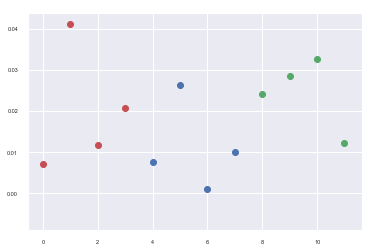

In [112]:
ik = 0
for nodes in set(df_gs['num_nodes']):
    for alpha in [.001, .00005]:
        diff_layers = df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==4)]['score'].values
        plt.scatter(ik, np.abs(diff_layers), color = 'r')
        ik += 1

for nodes in set(df_gs['num_nodes']):
    for layer in set(df_gs['num_layers']):
        diff_layers = df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==.001) & (df_gs['num_layers']==layer)]['score'].values-df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==.00005) & (df_gs['num_layers']==layer)]['score'].values
        plt.scatter(ik, np.abs(diff_layers), color = 'b')
        ik += 1
        
for alpha in [.001, .00005]:
    for layer in set(df_gs['num_layers']):
        diff_layers = df_gs[(df_gs['num_nodes'] == 100)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==layer)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==layer)]['score'].values
        plt.scatter(ik, np.abs(diff_layers), color = 'g')
        ik += 1
        
# red is the difference between numlayers
# blue is difference in alpha
# green is difference in nodes

I would read that high point as: The number of layers is most important given an alpha value of 'a1' and a number of nodes per layer of 'b1'.  The second highest point, however, indicates that the number of nodes is most important given a value of alpha 'a2' (where 'a2' may equal 'a1') and the number of layers equals 'l2'. 

My suspicion is that different parameters are more or less important in light of specific other parameter values.  

### Grid Search 2....
I repeated the grid search with more extreme parameter differences: 3 & 5 layers with hidden layers that were half of the input and output layers

In [117]:
# Try one more with stronger differnces between parameters
from sklearn.model_selection import GridSearchCV

params = {'hidden_layer_sizes':[(200,100,200), (200,100,100,100,200), (100,50,100), (100,50,50,50,100)], 'alpha': [0.001, 0.00005], 'verbose': [True]}

mlp = MLPClassifier()
mpl_gscv = GridSearchCV(mlp, params, cv=4, n_jobs = -1)
mpl_gscv.fit(X_sub_train, y_sub_train)

Iteration 1, loss = 1.30939423
Iteration 2, loss = 0.93240049
Iteration 3, loss = 0.89857709
Iteration 4, loss = 0.89101392
Iteration 5, loss = 0.86307930
Iteration 6, loss = 0.81374507
Iteration 7, loss = 0.81027995
Iteration 8, loss = 0.77851927
Iteration 9, loss = 0.74943165
Iteration 10, loss = 0.75588366
Iteration 11, loss = 0.72636265
Iteration 12, loss = 0.72272378
Iteration 13, loss = 0.72101129
Iteration 14, loss = 0.70780904
Iteration 15, loss = 0.69929977
Iteration 16, loss = 0.69541585
Iteration 17, loss = 0.69426319
Iteration 18, loss = 0.68040868
Iteration 19, loss = 0.68708933
Iteration 20, loss = 0.67536747
Iteration 21, loss = 0.67141804
Iteration 22, loss = 0.66847143
Iteration 23, loss = 0.66299603
Iteration 24, loss = 0.66946784
Iteration 25, loss = 0.68397032
Iteration 26, loss = 0.66359693
Iteration 27, loss = 0.67109821
Iteration 28, loss = 0.65195835
Iteration 29, loss = 0.65057246
Iteration 30, loss = 0.65335593
Iteration 31, loss = 0.64768851
Iteration 32, los

GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(200, 100, 200), (200, 100, 100, 100, 200), (100, 50, 100), (100, 50, 50, 50, 100)], 'alpha': [0.001, 5e-05], 'verbose': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [131]:
mpl_gscv.best_estimator_.score(X_sub_test, y_sub_test)

0.82364413772410172

Not bad!  Performs better on the test set than the cross validation split.  

In [122]:
param_d2 = {}
params = []
df_d = {'alpha': [], 'num_layers': [],'num_nodes':[] , 'score':[]}

for ik, entry in enumerate(mpl_gscv.cv_results_['params']):
    df_d['alpha'].append(entry['alpha'])
    df_d['num_layers'].append(len(entry['hidden_layer_sizes']))
    df_d['num_nodes'].append(entry['hidden_layer_sizes'][1])
    df_d['score'].append(mpl_gscv.cv_results_['mean_test_score'][ik])                      

In [123]:
df_gs = pd.DataFrame(df_d)

In [125]:
# differences between scores with constant num_nodes
# alpha values are the indices
# num_nodes = 100
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==5)]['score'].values


array([-0.04868595, -0.017779  ])

In [126]:
# differences between scores with constant num_nodes
# alpha values are the indices
# num_nodes = 50
df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==5)]['score'].values


array([-0.01697882, -0.0235553 ])

In [127]:
# differences between scores with constant num_layers
# alpha values are the indices
# num_layers = 3
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==3)]['score'].values


array([-0.01590358,  0.01675377])

In [128]:
# differences between scores with constant num_layers
# alpha values are the indices
# num_layers = 4
df_gs[(df_gs['num_nodes'] == 100)& (df_gs['num_layers']==5)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['num_layers']==5)]['score'].values


array([ 0.01580356,  0.01097747])

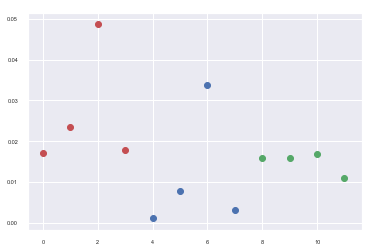

In [129]:
ik = 0
for nodes in set(df_gs['num_nodes']):
    for alpha in [.001, .00005]:
        diff_layers = df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==3)]['score'].values-df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==5)]['score'].values
        plt.scatter(ik, np.abs(diff_layers), color = 'r')
        ik += 1

for nodes in set(df_gs['num_nodes']):
    for layer in set(df_gs['num_layers']):
        diff_layers = df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==.001) & (df_gs['num_layers']==layer)]['score'].values-df_gs[(df_gs['num_nodes'] == nodes)& (df_gs['alpha']==.00005) & (df_gs['num_layers']==layer)]['score'].values
        plt.scatter(ik, np.abs(diff_layers), color = 'b')
        ik += 1
        
for alpha in [.001, .00005]:
    for layer in set(df_gs['num_layers']):
        diff_layers = df_gs[(df_gs['num_nodes'] == 100)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==layer)]['score'].values-df_gs[(df_gs['num_nodes'] == 50)& (df_gs['alpha']==alpha) & (df_gs['num_layers']==layer)]['score'].values
        plt.scatter(ik, np.abs(diff_layers), color = 'g')
        ik += 1
        
# red is the difference between numlayers
# blue is difference in alpha
# green is difference in nodes